# 1. Handling Libraries

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install networkx
# %pip install matplotlib
# %pip install datashader
# %pip install vl-convert-python
# %pip install svgutils
# %pip install lxml

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datashader.bundling import hammer_bundle
import vl_convert as vlc
import svgutils.transform as st
from lxml import etree
import xml.etree.ElementTree as ET
from collections import Counter
import json
import io
import re

pd.options.display.max_columns = None

# 2. Data Paths

In [3]:
# nodes_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-nodes.csv" 
# edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-edges.csv"
# blood_edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-blood-vasculature-edges.csv"

#use build_network.py to build data for latest release and save it in folder data
# data_version = 'v2.2'
# data_folder = f'All_Versions/data/data_{data_version}/'

# nodes_url = f"{data_folder}asct-nodes.csv" 
# edges_url = f"{data_folder}asct-edges.csv"
# blood_edges_url = f"{data_folder}asct-blood-vasculature-edges.csv"

# output_path = f'All_Versions/viz/viz_{data_version}/'

nodes_url = "data/asct-nodes.csv" 
edges_url = "data/asct-edges.csv"
# blood_edges_url = "data/asct-blood-vasculature-edges.csv"

# vessel_url = "data/Vessel.csv"
ftu_vessel_url = 'data/Table_S1.csv'

output_path = "./viz_v2.0"

## Make sure to save vega_config file in output_path/vega_config/

canvas_size = 1720

# 3. Algorithm and visualization logic

## 3.1 Process nodes and edges

In [4]:
nodes = pd.read_csv(nodes_url)
edges = pd.read_csv(edges_url)

In [5]:
omitted_organs = ['muscular_system', 'skeleton', 'lymph_vasculature', 'peripheral_nervous_system', 'blood_pelvis']

organ_order = ['trachea', 'main bronchus', 'respiratory system', 'mouth', 'heart', 'spinal cord', 'brain', 'eye', 'palatine tonsil', 
               'skin of body', 'thymus', 'lymph node', 'spleen',  'liver', 'Pancreas', 'small intestine',  'large intestine', 
               'kidney', 'urinary bladder', 'ureter', 'prostate gland',  'ovary', 'fallopian tube', 'uterus',  
               'placenta', 'knee', 'Bone marrow']

In [6]:
nodes = nodes[~nodes['organ'].isin(omitted_organs)]
edges = edges[~edges['organ'].isin(omitted_organs)]

## 3.2 Edges refinement.

In [7]:
## Detach respiratory system nodes from body and attach to lung.
respiratory_system_nodes = ['UBERON:0008886', 'UBERON:0004573', 'UBERON:0003920']

new_edges = edges[(edges['source']=='UBERON:0013702')&(edges['target'].isin(respiratory_system_nodes))].copy()
#connect the nodes to respiratory system instead of body
new_edges['source'].replace('UBERON:0013702', 'UBERON:0001004', inplace=True) 

#Update the edges
edges = edges[~((edges['source']=='UBERON:0013702')&(edges['target'].isin(respiratory_system_nodes)))]
edges = pd.concat([edges, new_edges])

In [8]:
whole_graph = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr=True)
nx.is_tree(whole_graph)

True

In [9]:
whole_graph

## 3.3 Nodes refinement

In [10]:
def get_nodes(name=None, ontology_id=None):
    if name:
        return nodes[nodes['name'].str.lower()==name.lower()]
    if ontology_id:
        return nodes[nodes['ontology_id']==ontology_id]

In [11]:
# organ_order_in_id = [get_nodes(name=organ)['id'].values[0] for organ in organ_order]

organ_order_in_id = []

for organ in organ_order:
    if len(get_nodes(name=organ)) > 0:
        organ_order_in_id += (list(get_nodes(name=organ)['id'].values))

In [12]:
def get_organ_graph(organ_id):
    organ_graph = whole_graph.copy()
    organ_graph.remove_edge('UBERON:0013702', organ_id) #remove the edge between body and the organ

    connected_components = sorted(list(nx.connected_components(organ_graph)), key=len, reverse=False) #get the connected components

    return nx.subgraph(organ_graph, connected_components[0]) #return the smallest connected component

In [13]:
#List of ontology ids of the organs that are branching out from body
organs_origin_body_id = list(nodes[nodes['ontology_id'].isin(list(nx.neighbors(whole_graph, 'UBERON:0013702')))]['ontology_id'])

#Get the updated list of organ ids in order containing only ids that are connected to the body node.
new_organ_order_in_id = []
for organ_id in organ_order_in_id:
    if organ_id in organs_origin_body_id:
        new_organ_order_in_id.append(organ_id)

organ_order_in_id = new_organ_order_in_id

In [14]:
## Generate a new integer-based ID, that takes into account the organ order
#(This is necesary for the layout, later we can order the nodes and edges based on this integer ID, and then vega will visualize the organs in the desired order)

id_to_graph_int_id = {'UBERON:0013702': 0}

next_id = 1

for i, organ_id in enumerate(organ_order_in_id):
    branch_graph = get_organ_graph(organ_id)

    branch_graph_new_ids = dict(zip(nx.dfs_preorder_nodes(branch_graph, source=organ_id), range(next_id, next_id+branch_graph.number_of_nodes())))

    id_to_graph_int_id.update(branch_graph_new_ids)

    next_id += branch_graph.number_of_nodes()


In [15]:
nodes['graph_int_id'] = nodes['id'].map(id_to_graph_int_id)

In [16]:
edges['source_int'] = edges['source'].map(id_to_graph_int_id)
edges['target_int'] = edges['target'].map(id_to_graph_int_id)

In [17]:
whole_graph_int = nx.from_pandas_edgelist(edges, source='source_int', target='target_int', edge_attr=True)

In [18]:
graph_int_id_to_id = {v: k for k, v in id_to_graph_int_id.items()}

In [19]:
# id_to_graph_int_id

## 3.4 Testing out nodes and edges (Skippable)

In [20]:
edges['organ'].value_counts()

blood_vasculature    4543
ovary                2070
large_intestine      1330
allen_brain           868
uterus                696
heart                 256
lung                  206
spleen                200
small_intestine       185
pancreas              175
fallopian_tube        174
placenta              166
kidney                157
lymph_node            128
spinal_cord           127
thymus                106
skin                   93
eye                    85
palatine_tonsil        70
bone_marrow            50
liver                  48
trachea                37
mouth                  35
prostate               34
urinary_bladder        32
knee                   29
main_bronchus          26
ureter                 21
Name: organ, dtype: int64

In [21]:
edges

,organ,source,target,source_type,target_type,source_int,target_int
0,blood_vasculature,UBERON:0013702,UBERON:0000948,AS,AS,0,297
1,allen_brain,UBERON:0013702,UBERON:0000955,AS,AS,0,5231
3,bone_marrow,UBERON:0013702,UBERON:0002371,AS,AS,0,11898
4,eye,UBERON:0013702,UBERON:0000970,AS,AS,0,6099
5,fallopian_tube,UBERON:0013702,UBERON:0003889,AS,AS,0,10833
...,...,...,...,...,...,...,...
11975,uterus,UBERON:0012276$$8720,ASCTB-TEMP:glandular-epithelial-cell$$8721,AS,CT,11693,11694
11976,uterus,UBERON:0011949$$8722,ASCTB-TEMP:luminal-epithelial-cell$$8723,AS,CT,11695,11696
11,lung,UBERON:0001004,UBERON:0008886,AS,AS,56,239
12,lung,UBERON:0001004,UBERON:0004573,AS,AS,56,250


In [22]:
nodes.duplicated(subset=['id', 'type', 'organ', 'ontology_id']).sum()

0

In [23]:
nodes.duplicated(subset=['id'], keep=False).sum()

0

In [24]:
nodes

,id,name,type,organ,ontology_id,graph_int_id
0,UBERON:0013702,body,AS,body,UBERON:0013702,0
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948,297
2,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079,298
3,CL:0010008,cardiac endothelial cell,CT,blood_vasculature,CL:0010008,299
4,FMA:49913,Left inferior pulmonary vein,AS,blood_vasculature,FMA:49913,300
...,...,...,...,...,...,...
11973,UBERON:0002451$$8719,endometrial gland,AS,uterus,UBERON:0002451,11692
11974,UBERON:0012276$$8720,endometrium glandular epithelium,AS,uterus,UBERON:0012276,11693
11975,ASCTB-TEMP:glandular-epithelial-cell$$8721,glandular epithelial cell,CT,uterus,ASCTB-TEMP:glandular-epithelial-cell,11694
11976,UBERON:0011949$$8722,endometrium luminal epithelium,AS,uterus,UBERON:0011949,11695


In [25]:
nodes.isna().sum()

id              0
name            0
type            0
organ           0
ontology_id     0
graph_int_id    0
dtype: int64

In [26]:
nodes.loc[nodes['name'].isna()]

,id,name,type,organ,ontology_id,graph_int_id


In [27]:
# Nodes that are branching from the 'body' node

nodes[nodes['ontology_id'].isin(list(nx.neighbors(whole_graph, 'UBERON:0013702')))]

,id,name,type,organ,ontology_id,graph_int_id
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948,297
4547,UBERON:0000955,brain,AS,allen_brain,UBERON:0000955,5231
5445,UBERON:0002371,Bone marrow,AS,bone_marrow,UBERON:0002371,11898
5495,UBERON:0000970,eye,AS,eye,UBERON:0000970,6099
5580,UBERON:0003889,fallopian tube,AS,fallopian_tube,UBERON:0003889,10833
6007,UBERON:0002113,kidney,AS,kidney,UBERON:0002113,8519
6164,UBERON:0001465,knee,AS,knee,UBERON:0001465,11869
6193,UBERON:0000059,large intestine,AS,large_intestine,UBERON:0000059,7189
7523,UBERON:0002107,liver,AS,liver,UBERON:0002107,6781
7571,UBERON:0001004,respiratory system,AS,lung,UBERON:0001004,56


In [28]:
id_to_graph_int_id['UBERON:0013702']

0

In [29]:
graph_int_id_to_id[0]

'UBERON:0013702'

In [30]:
nodes[nodes['organ'] == 'blood_vasculature']

,id,name,type,organ,ontology_id,graph_int_id
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948,297
2,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079,298
3,CL:0010008,cardiac endothelial cell,CT,blood_vasculature,CL:0010008,299
4,FMA:49913,Left inferior pulmonary vein,AS,blood_vasculature,FMA:49913,300
5,CL:0000071,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071,301
...,...,...,...,...,...,...
4542,FMA:8619,Right posterior segmental artery,AS,blood_vasculature,FMA:8619,4960
4543,CL:0000071$$3472,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071,4961
4544,CL:1000413$$3473,endothelial cell of artery,CT,blood_vasculature,CL:1000413,4962
4545,CL:0000057$$3474,fibroblast,CT,blood_vasculature,CL:0000057,4963


In [31]:
edges[edges['organ'] == 'blood_vasculature']

,organ,source,target,source_type,target_type,source_int,target_int
0,blood_vasculature,UBERON:0013702,UBERON:0000948,AS,AS,0,297
31,blood_vasculature,UBERON:0000948,UBERON:0002079,AS,AS,297,298
32,blood_vasculature,UBERON:0000948,UBERON:0002084,AS,AS,297,371
33,blood_vasculature,UBERON:0000948,UBERON:0002078,AS,AS,297,3617
34,blood_vasculature,UBERON:0000948,UBERON:0002080,AS,AS,297,4784
...,...,...,...,...,...,...,...
4620,blood_vasculature,FMA:8617,CL:0000359$$3471,AS,CT,4955,4959
4621,blood_vasculature,FMA:8619,CL:0000071$$3472,AS,CT,4960,4961
4622,blood_vasculature,FMA:8619,CL:1000413$$3473,AS,CT,4960,4962
4623,blood_vasculature,FMA:8619,CL:0000057$$3474,AS,CT,4960,4963


## 3.5 Removal of the blood vasculature nodes from the whole (partonomy) graph
We only keep those that are necessary to keep the network connected

In [32]:
# remove those blood nodes from the graph, which if we remove, the graph will be still connected, repeat until no such node is found.
blood_nodes_candidates = set(nodes[nodes['organ']=='blood_vasculature'].graph_int_id.tolist())

distance_from_body = nx.single_source_shortest_path_length(whole_graph_int, source=0)

distance_from_body_blood_nodes = {k: v for k, v in distance_from_body.items() if k in blood_nodes_candidates}

node_visiting_order = sorted(distance_from_body_blood_nodes.items(), key=lambda x: x[1], reverse=True)

new_truncated_graph = whole_graph_int.copy()

for node in node_visiting_order:
    new_truncated_graph.remove_node(node[0])
    if nx.is_connected(new_truncated_graph):
        blood_nodes_candidates.remove(node[0])
    else:
        break

nodes['keep'] = nodes.apply(lambda row: True if (row['organ']!='blood_vasculature' or row['graph_int_id'] in blood_nodes_candidates) else False, axis=1)

In [33]:
truncated_nodes = nodes[nodes['keep']]
truncated_edges = edges[edges['source_int'].isin(truncated_nodes['graph_int_id']) | edges['target_int'].isin(truncated_nodes['graph_int_id'])]
truncated_graph = nx.from_pandas_edgelist(truncated_edges, source='source_int', target='target_int', edge_attr=True)

In [34]:
FTUs = ['UBERON:0001285', 'UBERON:0001229', 'UBERON:0004205', 'UBERON:0001289', 'UBERON:0004193', 'UBERON:0004204', 'UBERON:0001291', 'UBERON:0004203', #kidney
        'UBERON:0001983',  'UBERON:0001984',  #large intestine
        'UBERON:0004647', #liver
        'UBERON:0002299', 'UBERON:8410043', #lung 
        'UBERON:0000006', 'UBERON:0001263', 'UBERON:0014726', #pancreas
        'UBERON:0004179', #prostate gland
        'UBERON:0000412', 'UBERON:0013487', 'UBERON:0002073', #skin
        'UBERON:0001213', #small intestine
        'UBERON:0001250', 'UBERON:0001959', #spleen
        'UBERON:0002125', #thymus
        'UBERON:0001831', 'UBERON:0001832', 'UBERON:0001736' #mouth
        ]
# UBERON:0001992 #skin

In [35]:
Main_Organs = list(nodes[nodes['ontology_id'].isin(list(nx.neighbors(whole_graph, 'UBERON:0013702')))]['id'])

## 3.6 Statistics for Male and Female Graphs (Skippable)

In [36]:
def process_nodes(nodes, truncated_nodes, truncated_edges, FTUs, gender='female'):
    """
    Process nodes based on gender and FTU inclusion.

    Parameters:
        nodes (DataFrame): The input nodes DataFrame.
        truncated_nodes (DataFrame): Nodes DataFrame after truncation.
        truncated_edges (DataFrame): Edges DataFrame after truncation.
        FTUs (set): Set of FTU ontology IDs.
        gender (str): Gender type ('female', 'male', 'full').

    Returns:
        dict: A dictionary with FTU counters and filtered DataFrame.
    """

    # Gender-specific filtering
    if gender == 'female':
        nodes_filtered = nodes[nodes['organ'] != 'prostate']
    elif gender == 'male':
        exclude_organs = ['fallopian_tube', 'ovary', 'uterus', 'placenta']
        nodes_filtered = nodes[~nodes['organ'].isin(exclude_organs)]
    else:
        nodes_filtered = nodes

    # FTU lists
    ftu_list = [oid for oid in nodes_filtered['ontology_id'] if oid in FTUs]
    ftu_name_list = [row['name'] for _, row in nodes_filtered.iterrows() if row['ontology_id'] in FTUs]

    # Counters for ontology IDs and names
    ftu_dict = Counter(ftu_list)
    ftu_dict_name = Counter(ftu_name_list)

    # Print FTU names counter
    print(f"FTU names and count ({gender}):\n", ftu_dict_name)

    # Conditions
    condition1 = nodes_filtered['keep'] == True
    condition2 = nodes_filtered['type'] == 'AS'
    condition3 = nodes_filtered['type'] == 'CT'
    condition4 = nodes_filtered['ontology_id'].isin(FTUs)

    # Printing counts based on conditions
    print(f"\nCount of nodes (AS) ({gender}):", len(nodes_filtered[condition1 & condition2]), len(nodes_filtered[condition1 & condition2]['ontology_id'].unique()))
    print(f"\nCount of nodes (CT) ({gender}):", len(nodes_filtered[condition1 & condition3]), len(nodes_filtered[condition1 & condition3]['ontology_id'].unique()))
    print(f"\nCount of nodes (FTUs) ({gender}):", len(nodes_filtered[condition1 & condition4]), len(nodes_filtered[condition1 & condition4]['ontology_id'].unique()))

    # Sorting nodes and edges
    nodes_df = truncated_nodes.sort_values('graph_int_id').copy()
    edges_df = truncated_edges.sort_values('target_int').copy()

    # Create graph and calculate parents
    graph = nx.from_pandas_edgelist(edges_df, source='source_int', target='target_int', edge_attr=True)
    parents_dict = dict(nx.bfs_predecessors(graph, source=0))

    # Add parent to nodes DataFrame
    nodes_df['parent'] = nodes_df['graph_int_id'].map(parents_dict).fillna(0).astype(int)

    # Additional filtering for gender-specific nodes
    if gender == 'female':
        nodes_df = nodes_df[nodes_df['organ'] != 'prostate']
    elif gender == 'male':
        nodes_df = nodes_df[~nodes_df['organ'].isin(exclude_organs)]

    # Drop duplicates and reset index
    newdf = nodes_df.drop_duplicates(subset=['parent', 'graph_int_id'], keep='first').reset_index(drop=True)
    print(f"\nNumber of structural edges ({gender}):", len(newdf) - 1)

    return {
        'ftu_dict': ftu_dict,
        'ftu_dict_name': ftu_dict_name,
        'filtered_df': newdf
    }

In [37]:
result_female = process_nodes(nodes, truncated_nodes, truncated_edges, FTUs, 'female')

FTU names and count (female):
 Counter({'crypt of Lieberkuhn of large intestine': 10, 'Pancreatic acinus': 6, 'intercalated duct of pancreas': 6, 'islet of Langerhans': 6, 'intestinal villus': 4, 'hair follicle': 3, 'bronchus submucosal gland': 3, 'cortical collecting duct': 2, 'thick ascending limb of loop of Henle': 2, 'descending limb of loop of Henle': 2, 'alveolus of lung': 2, 'dermal papilla': 2, 'nephron': 1, 'Renal Corpuscle': 1, 'loop of Henle ascending limb thin segment': 1, 'outer medullary collecting duct': 1, 'inner medullary collecting duct': 1, 'liver lobule': 1, 'bronchial submucosal gland': 1, 'parotid gland': 1, 'sublingual gland': 1, 'submandibular gland': 1, 'epidermal ridge of digit': 1, 'red pulp of spleen': 1, 'white pulp of spleen': 1, 'thymus lobule': 1})

Count of nodes (AS) (female): 3418 1436

Count of nodes (CT) (female): 5026 1151

Count of nodes (FTUs) (female): 62 25

Number of structural edges (female): 8443


In [38]:
result_male = process_nodes(nodes, truncated_nodes, truncated_edges, FTUs, 'male')

FTU names and count (male):
 Counter({'crypt of Lieberkuhn of large intestine': 10, 'Pancreatic acinus': 6, 'intercalated duct of pancreas': 6, 'islet of Langerhans': 6, 'intestinal villus': 4, 'hair follicle': 3, 'bronchus submucosal gland': 3, 'cortical collecting duct': 2, 'thick ascending limb of loop of Henle': 2, 'descending limb of loop of Henle': 2, 'alveolus of lung': 2, 'dermal papilla': 2, 'nephron': 1, 'Renal Corpuscle': 1, 'loop of Henle ascending limb thin segment': 1, 'outer medullary collecting duct': 1, 'inner medullary collecting duct': 1, 'liver lobule': 1, 'bronchial submucosal gland': 1, 'parotid gland': 1, 'sublingual gland': 1, 'submandibular gland': 1, 'Prostate Glandular Acinus': 1, 'epidermal ridge of digit': 1, 'red pulp of spleen': 1, 'white pulp of spleen': 1, 'thymus lobule': 1})

Count of nodes (AS) (male): 1733 1210

Count of nodes (CT) (male): 3639 1110

Count of nodes (FTUs) (male): 63 26

Number of structural edges (male): 5371


In [39]:
result_full = process_nodes(nodes, truncated_nodes, truncated_edges, FTUs, 'full')

FTU names and count (full):
 Counter({'crypt of Lieberkuhn of large intestine': 10, 'Pancreatic acinus': 6, 'intercalated duct of pancreas': 6, 'islet of Langerhans': 6, 'intestinal villus': 4, 'hair follicle': 3, 'bronchus submucosal gland': 3, 'cortical collecting duct': 2, 'thick ascending limb of loop of Henle': 2, 'descending limb of loop of Henle': 2, 'alveolus of lung': 2, 'dermal papilla': 2, 'nephron': 1, 'Renal Corpuscle': 1, 'loop of Henle ascending limb thin segment': 1, 'outer medullary collecting duct': 1, 'inner medullary collecting duct': 1, 'liver lobule': 1, 'bronchial submucosal gland': 1, 'parotid gland': 1, 'sublingual gland': 1, 'submandibular gland': 1, 'Prostate Glandular Acinus': 1, 'epidermal ridge of digit': 1, 'red pulp of spleen': 1, 'white pulp of spleen': 1, 'thymus lobule': 1})

Count of nodes (AS) (full): 3432 1447

Count of nodes (CT) (full): 5046 1164

Count of nodes (FTUs) (full): 63 26

Number of structural edges (full): 8477


## 3.7 Construct the Vega Viz files

In [40]:
def construct_network_create_vega_viz(nodes_dataframe, edges_dataframe, filename='butterfly', only_female=False, only_male=False, scenegraph=False, show_labels=False):
    '''
    Construct the network and create the vega visualization file, which is a JSON file. 
    Vega will visualize the network based on the config file. Using the API we can create the SVG and the "scenegraph" which will be used for the coordinates of the nodes.

    Parameters:
    nodes_dataframe: pd.DataFrame
        The dataframe containing the nodes of the network. It should have the following columns: 'id', 'name', 'type', 'organ', 'ontology_id', 'graph_int_id'.
    edges_dataframe: pd.DataFrame
        The dataframe containing the edges of the network. It should have the following columns: 'source_int', 'target_int', 'organ'.
    filename: str
        The name of the file to be saved
    only_female: bool
        If True, the visualization will not contain the prostate (so far that's the only male organ).
    only_male: bool
        If True, the visualization will not contain the ovaries, fallopian tube, uterus, placenta (so far these are the female organs).
    scenegraph: bool
        If True, the name of the nodes will be the id of the nodes. This is necessary to later get the coordinates of the nodes based on the IDs.
    show_labels: bool
        If True, the labels of the nodes will be shown (in the SVG file).
    '''

    nodes_df = nodes_dataframe.sort_values('graph_int_id').copy() 
    edges_df = edges_dataframe.sort_values('target_int').copy() #sorting is necessary for the order of the branches in the visualization

    # create the graph
    graph = nx.from_pandas_edgelist(edges_df, source='source_int', target='target_int', edge_attr=True)

    # get the parent of each node for the tree layout
    parents_dict = dict(nx.bfs_predecessors(graph, source=0))

    nodes_df['parent'] = nodes_df['graph_int_id'].map(parents_dict).fillna(0).astype(int)

    # set the color of the nodes based on the type
    nodes_df['color'] = nodes_df.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)


    # vega works with the id column, so we rename the id column to id_from_ontology_id
    nodes_df.rename(columns={'id': 'id_from_ontology_id', 'graph_int_id': 'id'}, inplace=True)
    

    if scenegraph:
        # the name has to be the id
        nodes_df.rename(columns={'name': 'name_label'}, inplace=True)
        nodes_df['name'] = nodes_df['id'].copy()


    # if the name is missing, we fill it with an empty string because vega gives an error if it is missing
    nodes_df['name'] = nodes_df['name'].fillna('')



    # from the female wing we remove the prostate
    if only_female and not only_male:
        nodes_df = nodes_df[nodes_df['organ']!='prostate']
        fn = filename + '_female'

    # from the male wing we remove the ovaries, fallopian tube, uterus, placenta
    elif only_male and not only_female:
        nodes_df = nodes_df[~nodes_df['organ'].isin(['fallopian_tube', 'ovary', 'uterus', 'placenta'])]
        fn = filename + '_male'

    elif not only_female and not only_male:
        fn = filename + '_full'

    else:
        raise ValueError('The parameters `only_female` and `only_male` cannot be both True at the same time.')

    # print(nodes_df['organ'].value_counts())

    # create the json file for the nodes
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 
                           'id_from_ontology_id', 'color', 'organ', #'organ_label'
                           ]].to_dict(orient='index')

    # the body does not have a parent, so we delete its value
    del(nodes_json[0]['parent'])

    # we need to convert the dictionary to a list, that's how the vega visualization expects it at the config['data'][0]['values']
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    
    # load the vega config file
    with open(f'{output_path}/vega_config/vega_config.json', encoding='utf8') as json_file:
        config = json.load(json_file)

    # set the data in the config file
    config['data'][0]['values'] = nodes_json
    
    # show labels if show_labels is True
    if show_labels:
        config['marks'][-1]['encode']['update']['opacity']['signal'] = config['marks'][-1]['encode']['update']['opacity']['signal'][:-1] + '1' # show the labels, by default they are hidden
    
    # create the json file and save it
    with open(f"{output_path}/{fn}_vega_viz_config.json", "w") as outfile:
        outfile.write(json.dumps(config, indent=4))
        print(f'File saved as "{output_path}/{fn}_vega_viz.json"')
    
    return config

In [41]:
def update_vega_config(vega_config_names, filename):
    for item in vega_config_names['data'][0]['values']:
        if item['ontology_id'] not in FTUs and item['ontology_id'] not in Main_Organs:
            item['name'] = ''
        
    with open(f"{output_path}/butterfly_names_{filename}_vega_viz_updated.json", "w") as outfile:
        outfile.write(json.dumps(vega_config_names, indent=4))
        print(f'File saved as "{output_path}/butterfly_names_{filename}_vega_viz_updated.json"')

    return vega_config_names

In [42]:
vega_config = construct_network_create_vega_viz(truncated_nodes, truncated_edges, scenegraph=True)

File saved as "./viz_v2.0/butterfly_full_vega_viz.json"


In [43]:
vega_config_female_with_ids = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=True, show_labels=True, filename='butterfly_ids') #id shown - this is used for the coordinates 
vega_config_female = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=True, show_labels=False) #no name or id shown, based on id (scenegraph) - this is used for the viz

File saved as "./viz_v2.0/butterfly_ids_female_vega_viz.json"
File saved as "./viz_v2.0/butterfly_female_vega_viz.json"


In [44]:
vega_config_male_with_ids = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=True, show_labels=True, filename='butterfly_ids')
vega_config_male = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=True)

File saved as "./viz_v2.0/butterfly_ids_male_vega_viz.json"
File saved as "./viz_v2.0/butterfly_male_vega_viz.json"


In [45]:
vega_config_female_with_names = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=False, show_labels=True, filename='butterfly_names') 
vega_config_female_with_names = update_vega_config(vega_config_female_with_names, 'female')

vega_config_male_with_names = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=False, show_labels=True, filename='butterfly_names') 
vega_config_male_with_names = update_vega_config(vega_config_male_with_names, 'male')

File saved as "./viz_v2.0/butterfly_names_female_vega_viz.json"
File saved as "./viz_v2.0/butterfly_names_female_vega_viz_updated.json"
File saved as "./viz_v2.0/butterfly_names_male_vega_viz.json"
File saved as "./viz_v2.0/butterfly_names_male_vega_viz_updated.json"


In [46]:
def create_vega_viz(config, filename, scenegraph=False):
    '''
    Create the visualization based on the vega config file. The visualization can be saved as SVG or as a scenegraph JSON file.

    Parameters:
    config: dict
        The vega config file.
    filename: str
        The name of the file to be saved.
    scenegraph: bool
        If True, the scenegraph JSON file will be saved, otherwise the SVG file will be saved.
    '''

    if scenegraph:
        scenegraph_data = vlc.vega_to_scenegraph(vg_spec=config)

        with open(f"{output_path}/vega_{filename}_scenegraph.json", "w") as outfile:
            outfile.write(json.dumps(scenegraph_data, indent=4))

        return scenegraph_data
    
    else:
        svg_str = vlc.vega_to_svg(vg_spec=config,)

        with open(f"{output_path}/vega_{filename}_viz.svg", "wt") as f:
            f.write(svg_str)

        return svg_str

In [47]:
%%time
female_svg_names = create_vega_viz(vega_config_female_with_names, 'female_name', scenegraph=False)

CPU times: user 1.02 s, sys: 259 ms, total: 1.28 s
Wall time: 1.28 s


In [48]:
%%time
male_svg_names = create_vega_viz(vega_config_male_with_names, 'male_name', scenegraph=False)

CPU times: user 365 ms, sys: 107 ms, total: 472 ms
Wall time: 356 ms


In [49]:
%%time
# female_svg_names = create_vega_viz(vega_config_female, 'female', scenegraph=False)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


In [50]:
%%time
# male_svg_names = create_vega_viz(vega_config_male, 'male', scenegraph=False)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [51]:
scenegraph_female = create_vega_viz(vega_config_female_with_ids, 'female_id', scenegraph=True)
scenegraph_male = create_vega_viz(vega_config_male_with_ids, 'male_id', scenegraph=True)

In [52]:
def get_node_coordinates(scenegraph):
    return {item['text']: (item['x'], item['y']) for item in scenegraph['scenegraph']['items'][0]['items'][2]['items']}

In [53]:
coordinates_of_nodes_fem = get_node_coordinates(scenegraph_female)
coordinates_of_nodes_mal = get_node_coordinates(scenegraph_male)

## 3.8 Blood Vasculature 

In [54]:
ftu_vessel = pd.read_csv(ftu_vessel_url)[['FTU', 'FTUID', 'Vessel', 'VesselID', 'PathStep', 'PathVessel', 'PathVesselID']]

In [55]:
unique_pairs = ftu_vessel[['FTU', 'Vessel']].drop_duplicates()
unique_pairs

,FTU,Vessel
0,alveolus of lung,alveolar capillary
16,bronchus submucosal gland,bronchial capillary
31,cortical collecting duct,peritubular capillary
55,crypt of Lieberkuhn,branch of mucous plexus of colon
89,dermal papilla,branch of subpapillary plexus
110,descending limb of loop of Henle,ascending vasa recta of kidney
136,epidermal ridge of digit,branch of subpapillary plexus
157,inner medullary collecting duct,ascending vasa recta of kidney
183,inner medullary collecting duct,descending vasa recta of kidney
209,intercalated duct,periductal capillary of intercalated duct of p...


In [56]:
## Correct IDs for some PathVessels and FTUs 
ftu_vessel.loc[ftu_vessel['PathVessel'] == 'segmental pulmonary vein', ['PathVesselID']] = 'UBERON:8600051'
ftu_vessel.loc[ftu_vessel['FTU'] == 'intercalated duct', ['FTUID']] = 'UBERON:0014726'
ftu_vessel.loc[ftu_vessel['FTU'] == 'crypt of Lieberkuhn', ['FTUID']] = 'UBERON:0001984'

In [57]:
def get_node_id(nodes, ontology_id, node_name, node_type):
    # Normalize ID if it's in format like 'fma9283'
    if ontology_id and isinstance(ontology_id, str):
        match = re.match(r'^([a-zA-Z]+):?(\d+)$', ontology_id)
        if match:
            letters = match.group(1).upper()
            numbers = match.group(2)
            ontology_id = f"{letters}:{numbers}"

    # Match ID to node
    ontology_ids = nodes.loc[nodes['ontology_id'] == ontology_id, 'id'].tolist() if ontology_id else []
    if not ontology_ids:
        ontology_ids = nodes.loc[nodes['name'].str.lower() == node_name.lower(), 'id'].tolist()

    if not ontology_ids:
#         print(f'Missing {node_type} Name: {node_name}, {node_type} ID: {ontology_id}')
        ontology_ids = ['None']
        key = node_type+'_'+node_name
        if key not in missing_nodes:
            missing_nodes[key] = ontology_id
        
    return ontology_ids[0]

In [58]:
missing_nodes = {}
for index, row in ftu_vessel.iterrows():
    ftu_name = row['FTU']
    ftu_id = row['FTUID']
    vessel_name = row['Vessel']
    vessel_id = row['VesselID']
    path_vessel_name = row['PathVessel']
    path_vessel_id = row['PathVesselID']
    
    ftu_ids = get_node_id(nodes, ftu_id, ftu_name, 'FTU')
    ftu_vessel.loc[index,'FTUID_node'] = ftu_ids
    
    vessel_ids = get_node_id(nodes, vessel_id, vessel_name, 'Vessel')
    ftu_vessel.loc[index,'VesselID_node'] = vessel_ids
    
    path_vessel_ids = get_node_id(nodes, path_vessel_id, path_vessel_name, 'PathVessel')
    ftu_vessel.loc[index,'PathVesselID_node'] = path_vessel_ids
    
ftu_vessel = ftu_vessel.replace("None", pd.NA)

In [59]:
missing_nodes 

{'PathVessel_segmental pulmonary vein': 'UBERON:8600051',
 'PathVessel_cutaneous branch of ulnar artery': nan,
 'PathVessel_cutaneous branch of ulnar vein': nan}

In [60]:
#Add missing pathvessel id nodes
mask = ftu_vessel['PathVesselID_node'].isna() | (ftu_vessel['PathVesselID_node'] == '')

ftu_vessel.loc[mask, 'PathVesselID_node'] = np.where(
    ftu_vessel.loc[mask, 'PathVesselID'].notna() & (ftu_vessel.loc[mask, 'PathVesselID'] != ''),
    ftu_vessel.loc[mask, 'PathVesselID'],
    'ASCTB-TEMP:' + ftu_vessel.loc[mask, 'PathVessel'].astype(str)
)

#Drop empty FTUID_node
ftu_vessel = ftu_vessel.dropna(subset='FTUID_node').reset_index(drop=True)

In [61]:
ftu_vessel[ftu_vessel['PathVesselID_node'].isnull()]

,FTU,FTUID,Vessel,VesselID,PathStep,PathVessel,PathVesselID,FTUID_node,VesselID_node,PathVesselID_node


In [62]:
def build_initial_blood_edges(ftu_vessel_df, nodes_df, ftus_to_exclude=None):
    """
    Build initial blood vessel edges from FTU-vessel paths, excluding specified FTUs,
    and explicitly add heart to atria/ventricles connections.

    Parameters:
        ftu_vessel_df (pd.DataFrame): DataFrame with columns ['FTU', 'Vessel', 'PathVesselID_node', 'PathStep', 'FTUID_node', 'VesselID_node'].
        nodes_df (pd.DataFrame): DataFrame with columns ['ontology_id', 'type'].
        ftus_to_exclude (list[str], optional): List of FTU names to exclude (case-insensitive). Default: None.

    Returns:
        pd.DataFrame: DataFrame with columns ['organ', 'source', 'target', 'source_type', 'target_type', 'vessel_type'].
    """

    node_types = nodes_df.set_index('ontology_id')['type'].to_dict()
    new_blood_edges = []

    def make_edge(source, target, organ, vessel_type):
        return {
            'organ': organ,
            'source': source,
            'target': target,
            'source_type': node_types.get(source, 'unknown'),
            'target_type': node_types.get(target, 'unknown'),
            'vessel_type': vessel_type
        }

    exclude_ftus = set(ftu.lower() for ftu in ftus_to_exclude) if ftus_to_exclude else set()

    for (ftu, vessel), group in ftu_vessel_df.groupby(['FTU', 'Vessel']):
        if ftu.lower() in exclude_ftus:
            continue

        row = group.iloc[0]
        organ = 'blood_vasculature'
        path_df = group.dropna(subset=['PathVesselID_node']).sort_values('PathStep')

        arteries = path_df[path_df['PathStep'] <= 0].sort_values('PathStep')
        veins = path_df[path_df['PathStep'] >= 0].sort_values('PathStep', ascending=False)

        art_ids = arteries['PathVesselID_node'].tolist()
        new_blood_edges.extend([
            make_edge(art_ids[i], art_ids[i + 1], organ, 'artery')
            for i in range(len(art_ids) - 1)
        ])

        vein_ids = veins['PathVesselID_node'].tolist()
        new_blood_edges.extend([
            make_edge(vein_ids[i], vein_ids[i + 1], organ, 'vein')
            for i in range(len(vein_ids) - 1)
        ])

        # Vessel to FTU: add both artery and vein edges
        new_blood_edges.append(make_edge(row['VesselID_node'], row['FTUID_node'], organ, 'artery'))
        new_blood_edges.append(make_edge(row['VesselID_node'], row['FTUID_node'], organ, 'vein'))

    # Add heart → ventricle (artery), and heart → atria (vein) edges
    heart_id = 'UBERON:0000948'
    id_of_ventricles = ['UBERON:0002084', 'UBERON:0002080']
    id_of_atria = ['UBERON:0002079', 'UBERON:0002078']

    for ventricle_id in id_of_ventricles:
        new_blood_edges.append(make_edge(heart_id, ventricle_id, 'blood_vasculature', 'artery'))

    for atrium_id in id_of_atria:
        new_blood_edges.append(make_edge(heart_id, atrium_id, 'blood_vasculature', 'vein'))

    return pd.DataFrame(new_blood_edges)

In [63]:
def augment_edges_with_kept_nodes(edge_df, nodes_df):
    """
    Augments edges by replacing source and target ontology IDs with all kept node IDs.

    Parameters:
        edge_df (pd.DataFrame): DataFrame with at least ['source', 'target'] columns.
        nodes_df (pd.DataFrame): DataFrame with ['ontology_id', 'id', 'keep'] columns.

    Returns:
        pd.DataFrame: Augmented edge DataFrame (original + new combinations).
    """
    # Build lookup: ontology_id → list of kept node IDs
    kept_node_ids = nodes_df[nodes_df['keep'] == True].groupby('ontology_id')['id'].apply(list).to_dict()

    augmented_edges = []

    for _, r in edge_df.iterrows():
        source_ont = r['source']
        target_ont = r['target']

        alt_sources = kept_node_ids.get(source_ont, [])
        alt_targets = kept_node_ids.get(target_ont, [])

        # Alternate sources
        for new_source in alt_sources:
            if new_source != r['source']:
                new_edge = r.copy()
                new_edge['source'] = new_source
                augmented_edges.append(new_edge)

        # Alternate targets
        for new_target in alt_targets:
            if new_target != r['target']:
                new_edge = r.copy()
                new_edge['target'] = new_target
                augmented_edges.append(new_edge)

        # Both source and target replaced
        for new_source in alt_sources:
            for new_target in alt_targets:
                if new_source != r['source'] and new_target != r['target']:
                    new_edge = r.copy()
                    new_edge['source'] = new_source
                    new_edge['target'] = new_target
                    augmented_edges.append(new_edge)

    # Combine and return
    if augmented_edges:
        return pd.concat([edge_df, pd.DataFrame(augmented_edges)], ignore_index=True)
    else:
        return edge_df


In [64]:
def map_ids_and_coordinates(edge_df, id_map, coord_map, fill_value=1000000):
    """
    Maps internal graph IDs and coordinates to an edge DataFrame.

    Parameters:
        edge_df (pd.DataFrame): DataFrame with 'source' and 'target' columns.
        id_map (dict): Mapping from node ontology ID → internal graph ID (int).
        coord_map (dict): Mapping from internal graph ID (int) → coordinates.
        fill_value (int): Value to use when ID mapping is missing. Default is 1000000.

    Returns:
        pd.DataFrame: Modified edge DataFrame with added 'source_int', 'target_int',
                      'source_coord', 'target_coord' columns.
    """
    df = edge_df.copy()
    
    df['source_int'] = df['source'].map(id_map)
    df['target_int'] = df['target'].map(id_map)
    
    df[['source_int', 'target_int']] = df[['source_int', 'target_int']].fillna(fill_value).astype(int)

    df['source_coord'] = df['source_int'].map(coord_map)
    df['target_coord'] = df['target_int'].map(coord_map)
    
    return df


In [65]:
def generate_blood_edges(ftu_vessel_df, nodes_df, id_map, coord_map, ftus_to_exclude=None, fill_value=1000000):
    """
    Full pipeline to generate blood edges: initial build, augmentation, and coordinate mapping.

    Parameters:
        ftu_vessel_df (pd.DataFrame): FTU-vessel mapping data.
        nodes_df (pd.DataFrame): Node metadata including 'ontology_id', 'id', 'keep', and 'type'.
        id_map (dict): Mapping from ontology IDs to internal graph node IDs (int).
        coord_map (dict): Mapping from internal node IDs to coordinates.
        ftus_to_exclude (list): Optional list of FTU names (case-insensitive) to exclude. Default is None.
        fill_value (int): Fallback ID if mapping is missing. Default is 1000000.

    Returns:
        pd.DataFrame: Final edge DataFrame with internal IDs and coordinates.
    """
    # Step 1: Build initial blood edges
    initial_edges = build_initial_blood_edges(
        ftu_vessel_df=ftu_vessel_df,
        nodes_df=nodes_df,
        ftus_to_exclude=ftus_to_exclude
    )

    # Step 2: Augment with kept nodes
    augmented_edges = augment_edges_with_kept_nodes(initial_edges, nodes_df)

    # Step 3: Map IDs and coordinates
    final_edges = map_ids_and_coordinates(
        edge_df=augmented_edges,
        id_map=id_map,
        coord_map=coord_map,
        fill_value=fill_value
    )

    return final_edges


In [66]:
male_only_ftus = ['prostate glandular acinus']
female_only_ftus = None

In [67]:
female_blood_edges = generate_blood_edges(
    ftu_vessel_df=ftu_vessel,
    nodes_df=nodes,
    id_map=id_to_graph_int_id,
    coord_map=coordinates_of_nodes_fem,
    ftus_to_exclude=male_only_ftus)

female_blood_edges.drop_duplicates(inplace=True)
female_blood_edges.reset_index(drop=True, inplace=True)
female_blood_edges = female_blood_edges.sort_values(by='source_int').reset_index(drop=True)

In [68]:
male_blood_edges = generate_blood_edges(
    ftu_vessel_df=ftu_vessel,
    nodes_df=nodes,
    id_map=id_to_graph_int_id,
    coord_map=coordinates_of_nodes_mal,
    ftus_to_exclude=female_only_ftus)

male_blood_edges.drop_duplicates(inplace=True)
male_blood_edges.reset_index(drop=True, inplace=True)
male_blood_edges = male_blood_edges.sort_values(by='source_int').reset_index(drop=True)

In [69]:
#Statistics
print('Female arteries: ', len(female_blood_edges[female_blood_edges['vessel_type'] == 'artery']))
print('Female veins: ', len(female_blood_edges[female_blood_edges['vessel_type'] == 'vein']))
print('Male arteries: ', len(male_blood_edges[male_blood_edges['vessel_type'] == 'artery']))
print('Male veins: ', len(male_blood_edges[male_blood_edges['vessel_type'] == 'vein']))

Female arteries:  282
Female veins:  257
Male arteries:  290
Male veins:  264


## 3.9 Plot Blood Vessels

In [70]:
def generate_vessel_graph(blood_edges, vessel_type):
    # Filter based on vessel type (artery or vein)
    blood_edges_vessel = blood_edges[blood_edges['vessel_type'] == vessel_type]
    
    # Drop unnecessary columns
    blood_edges_vessel = blood_edges_vessel.drop(['organ', 'source_type', 'target_type', 'vessel_type', 'source', 'target'], axis=1)
    
    # Create dictionaries for source and target with non-null coordinates
    fixed_nodes_source = blood_edges_vessel.loc[blood_edges_vessel['source_coord'].notna(), ['source_int', 'source_coord']].set_index('source_int')['source_coord'].to_dict()
    fixed_nodes_target = blood_edges_vessel.loc[blood_edges_vessel['target_coord'].notna(), ['target_int', 'target_coord']].set_index('target_int')['target_coord'].to_dict()
    
    # Combine the two dictionaries
    combined_nodes = {**fixed_nodes_source, **fixed_nodes_target}
    
    # Remove duplicates, keeping the first occurrence
    fixed_pos = {}
    for key, value in combined_nodes.items():
        if value not in fixed_pos.values():
            fixed_pos[key] = value
    
    # Create the graph from the blood edges DataFrame
    G = nx.from_pandas_edgelist(blood_edges_vessel, source='source_int', target='target_int')
    
    # Calculate the spring layout
    pos = nx.spring_layout(
        G,
        pos=fixed_pos,
        fixed=list(fixed_pos.keys()),
        seed=42,                                # Ensures reproducibility
        iterations=1000,                        # More iterations for layout stability
        dim=2,                                  # 2D layout
        k=0.01 / np.sqrt(len(G))                # Optimal distance scaling based on graph size
    )
    
    return G, pos, list(fixed_pos.keys())

In [71]:
# For female arteries
G_fem_arteries, artery_pos_female, arteries_fixed_nodes_female = generate_vessel_graph(female_blood_edges, 'artery')

# For female veins
G_fem_veins, vein_pos_female, veins_fixed_nodes_female = generate_vessel_graph(female_blood_edges, 'vein')

# For male arteries
G_male_arteries, artery_pos_male, arteries_fixed_nodes_male = generate_vessel_graph(male_blood_edges, 'artery')

# For male veins
G_male_veins, vein_pos_male, veins_fixed_nodes_male = generate_vessel_graph(male_blood_edges, 'vein')

In [72]:
def plot_blood_vessels_with_bundling(G_arteries, G_veins, vein_pos, artery_pos, filename):
    '''
    Plot blood vessels (veins and arteries) with force-directed bundling using hammer bundle method.

    Parameters:
    - G_fem_arteries (networkx.Graph): Graph for female arteries.
    - G_fem_veins (networkx.Graph): Graph for female veins.
    - vein_pos_female (dict): Positions for the veins.
    - artery_pos_female (dict): Positions for the arteries.
    - canvas_size (int): Size of the canvas for plotting.
    - output_path (str): Path to save the resulting figure.
    '''
    
    # Create edges and nodes for veins and arteries
    edges = {
        'veins': nx.to_pandas_edgelist(G_veins, source='source_int', target='target_int')[['source_int', 'target_int']].rename(columns={'source_int': 'source', 'target_int': 'target'}),
        'arteries': nx.to_pandas_edgelist(G_arteries, source='source_int', target='target_int')[['source_int', 'target_int']].rename(columns={'source_int': 'source', 'target_int': 'target'})
    }
    
    nodes = {
        'veins': pd.DataFrame.from_dict(vein_pos).T.rename(columns={0: 'x', 1: 'y'}),
        'arteries': pd.DataFrame.from_dict(artery_pos).T.rename(columns={0: 'x', 1: 'y'})
    }
    
    # Apply the hammer bundle method (assumed to be implemented elsewhere)
    hb = {
        'veins': hammer_bundle(nodes['veins'], edges['veins'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000),
        'arteries': hammer_bundle(nodes['arteries'], edges['arteries'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)
    }
    
    # Create the plot
    plt.figure(figsize=(canvas_size / 100, canvas_size / 100))
    plt.axes().set_aspect('equal')
    plt.margins(x=0, y=0)
    plt.xlim(0, canvas_size)
    plt.ylim(-canvas_size, 0)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0, 0, 1, 1))
    plt.axis('off')

    # Plot the veins and arteries
    plt.plot(hb['veins']['x'], -hb['veins']['y'], color='tab:blue', alpha=0.8)
    plt.plot(hb['arteries']['x'], -hb['arteries']['y'], color='tab:red', alpha=0.8)

    # Adjust plot layout and margins
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0, 0, 1, 1))
    plt.axis('off')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Save the figure
    plt.savefig(f'{output_path}/blood_viz_{filename}_bundled.svg', pad_inches=0.0, transparent=True, bbox_inches=0)
    print(f'Fig saved as "{output_path}/blood_viz_{filename}_bundled.svg"')
    plt.show()


Fig saved as "./viz_v2.0/blood_viz_female_bundled.svg"


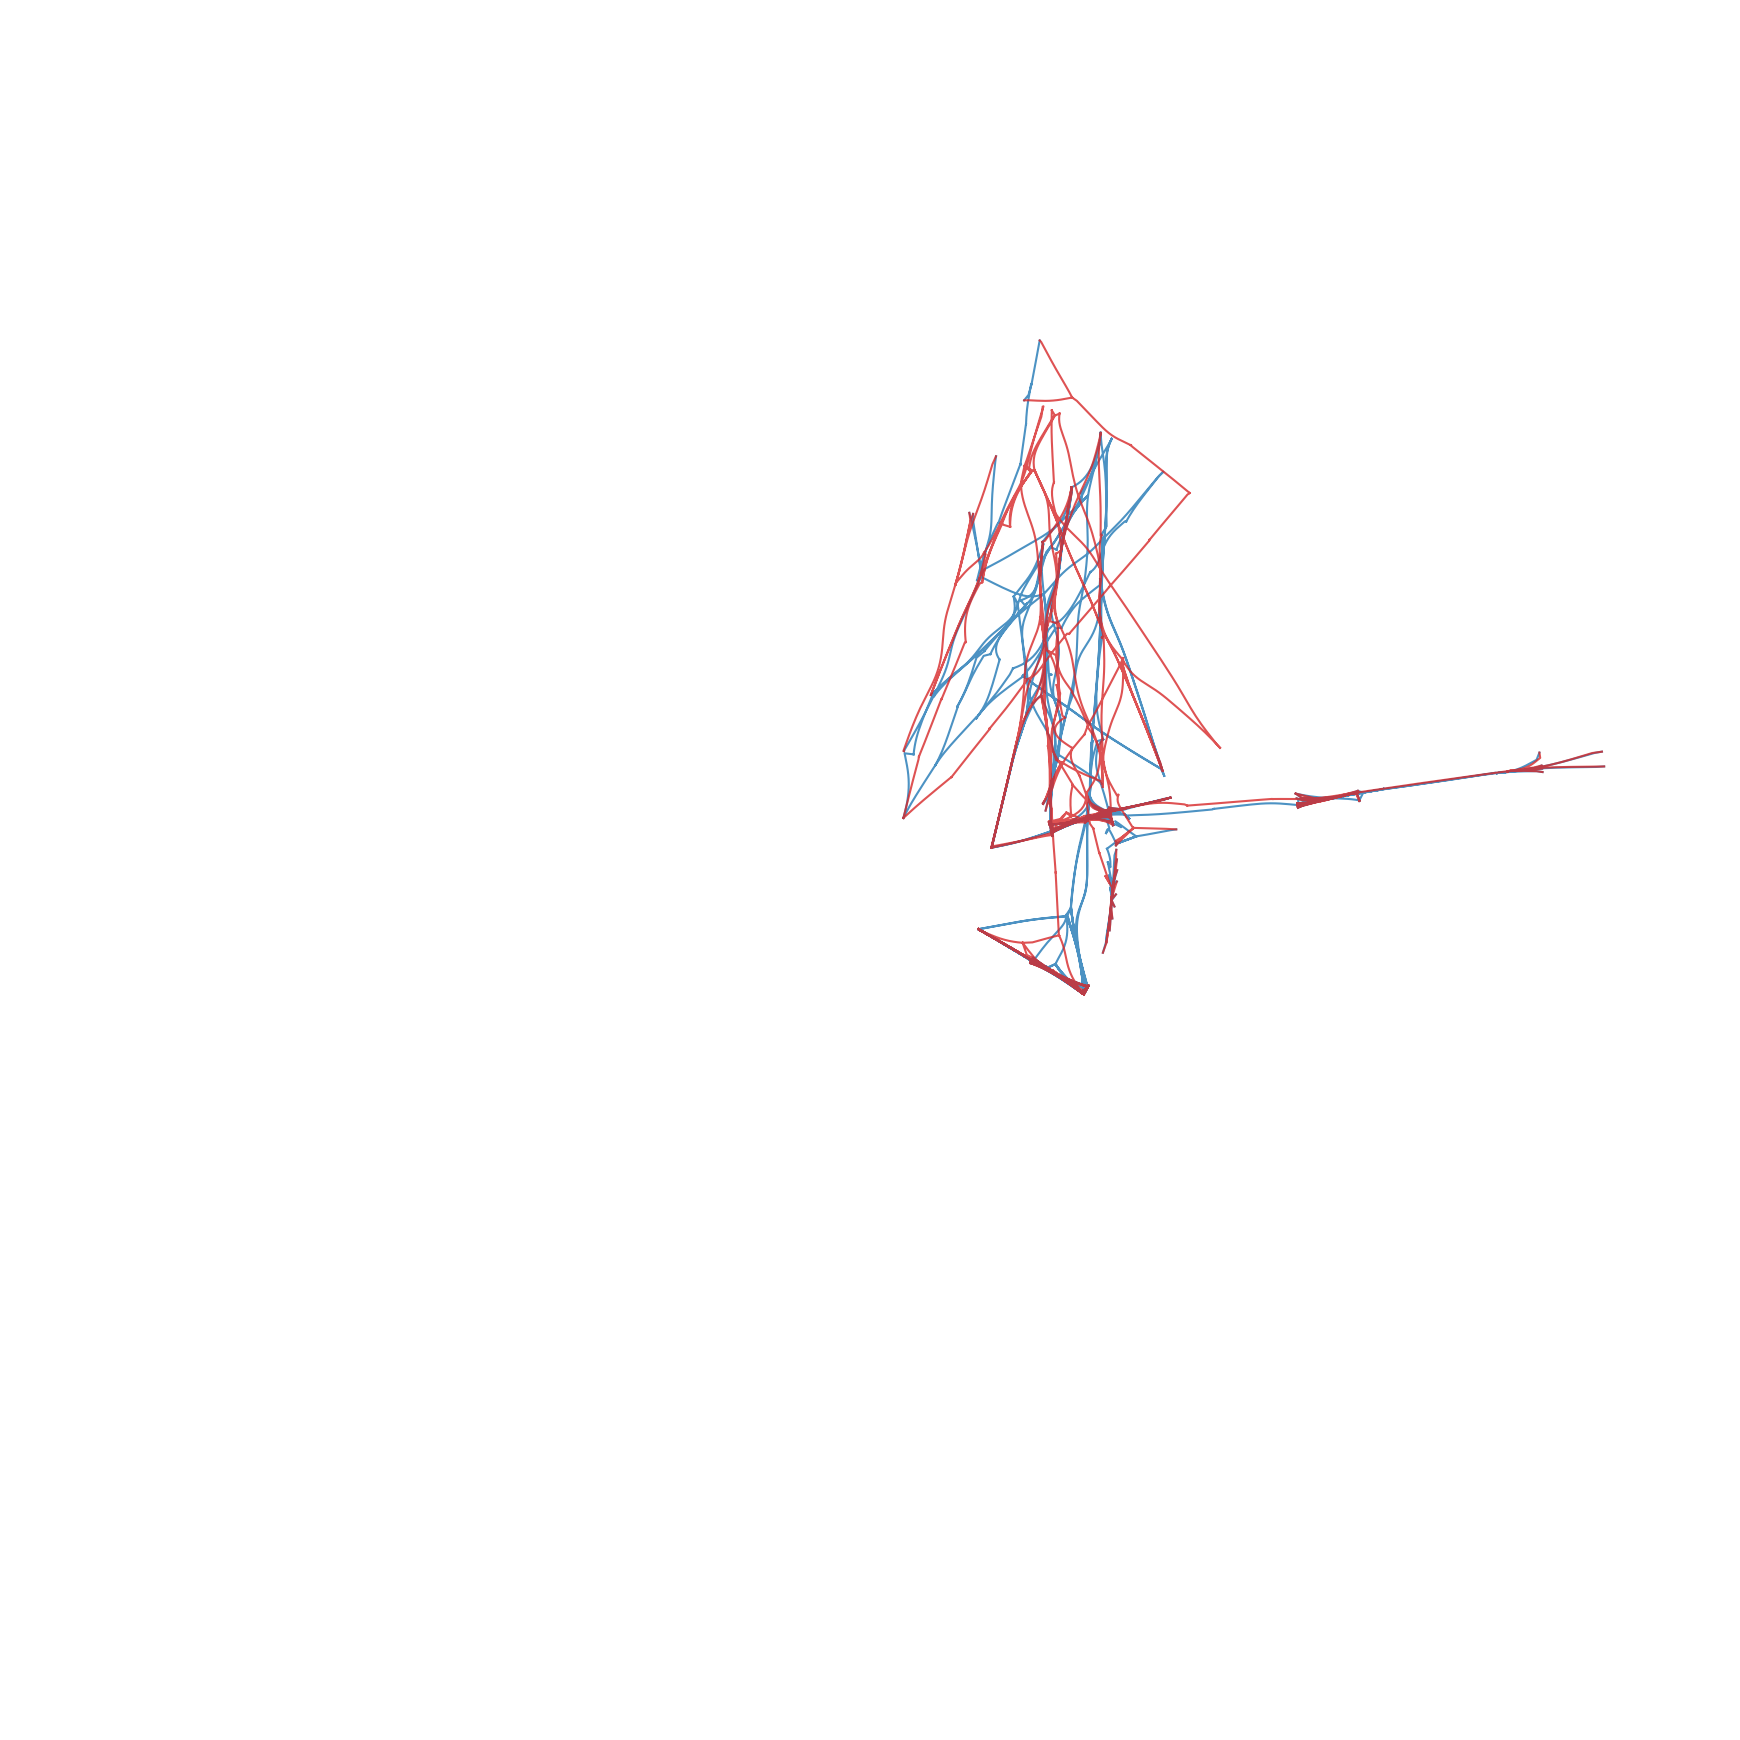

In [73]:
plot_blood_vessels_with_bundling(G_fem_arteries, G_fem_veins, vein_pos_female, artery_pos_female, 'female')

Fig saved as "./viz_v2.0/blood_viz_male_bundled.svg"


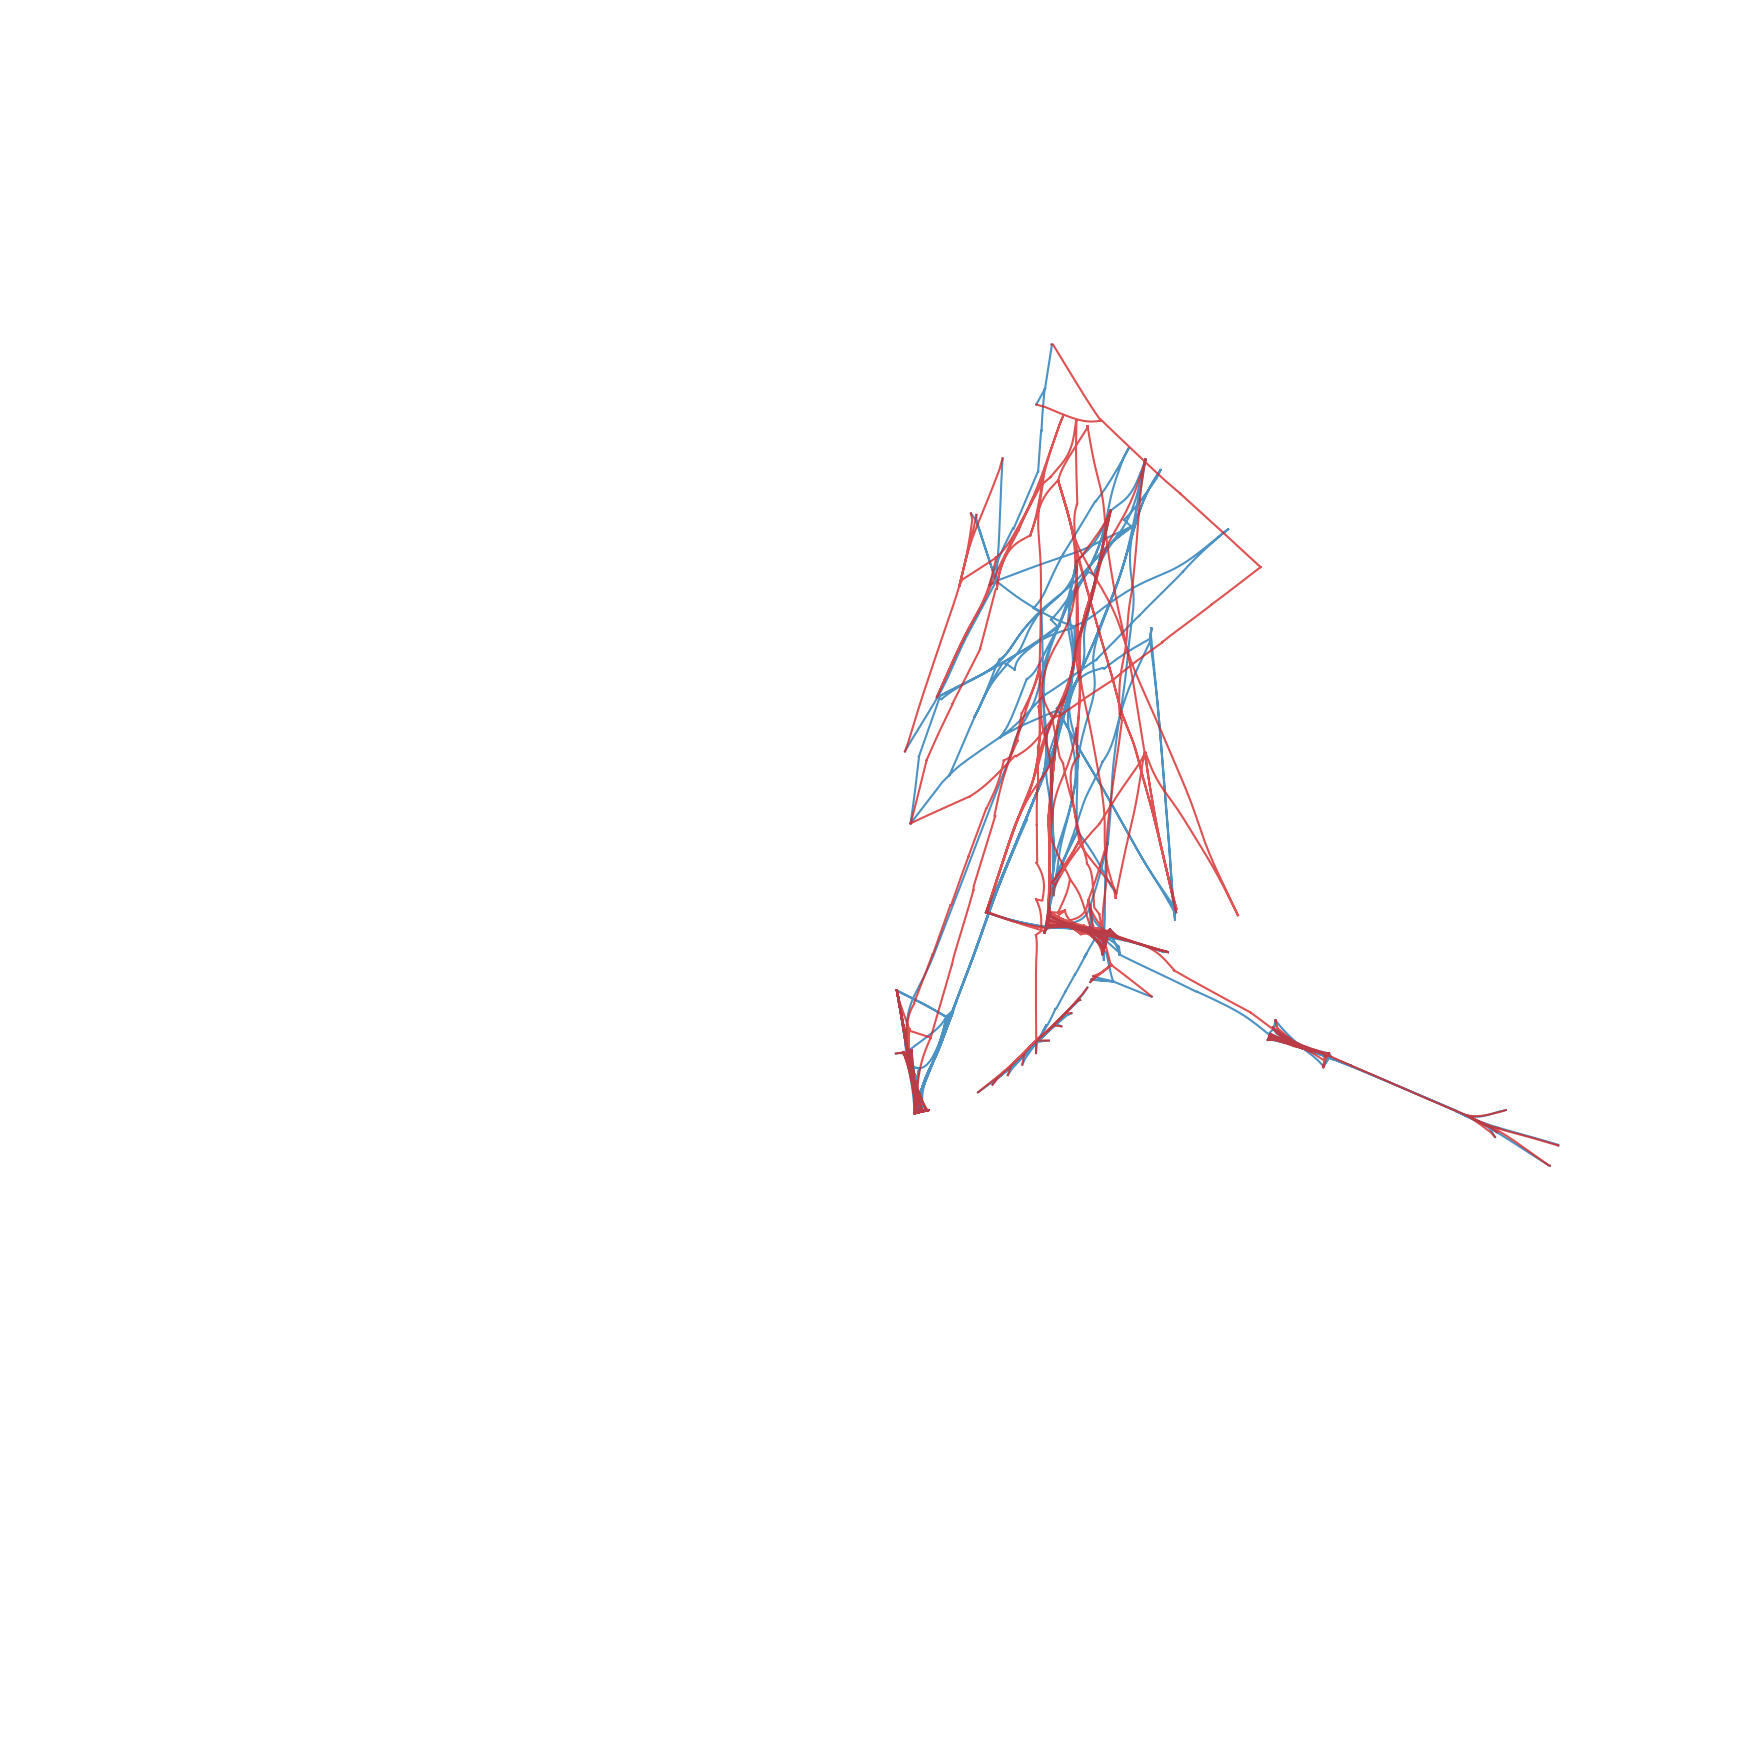

In [74]:
plot_blood_vessels_with_bundling(G_male_arteries, G_male_veins, vein_pos_male, artery_pos_male, 'male')

# 4. Overlay the SVG figures using svgutils

In [75]:
def flip_text_horizontally(input_file, output_file):
    # Parse the SVG file
    tree = ET.parse(input_file)
    root = tree.getroot()

    # Get the SVG namespace
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    ET.register_namespace('', ns['svg'])  # Prevent unnecessary prefixes in output

    # Loop through all text elements in the SVG
    for text_element in root.findall('.//svg:text', ns):
        # Get the text element's position (x, y)
        x = float(text_element.attrib.get('x', '0'))
        y = float(text_element.attrib.get('y', '0'))

        # Apply a transformation to flip the text horizontally
        current_transform = text_element.attrib.get('transform', '')
        flip_transform = f"translate({2 * x}, 0) scale(-1, 1)"
        text_element.set('transform', f"{current_transform} {flip_transform}".strip())

    # Save the modified SVG
    tree.write(output_file)
    print(f"Text-flipped SVG saved to {output_file}")

In [76]:
## Uncomment if flipping female wing.
# input_svg = f"{output_path}/vega_female_name_viz.svg"  # Path to your input SVG file
# output_svg = f"{output_path}/vega_female_name_viz_flipped.svg"
# flip_text_horizontally(input_svg, output_svg)

In [77]:
## Use first line if flipping female wing.
# template = st.fromfile(f'{output_path}/vega_female_name_viz_flipped.svg')
template = st.fromfile(f'{output_path}/vega_female_name_viz.svg')
template.set_size(size=(str(canvas_size), str(canvas_size)))
second_svg = st.fromfile(f'{output_path}/blood_viz_female_bundled.svg')
second_svg.set_size(size=(str(canvas_size), str(canvas_size)))

In [78]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) 

1720 1720
1720 1720


In [79]:
template.append(second_svg)
template.save(f'{output_path}/female_butterfly_wing.svg')

In [80]:
## Comment out if flipping female wing.
input_svg = f"{output_path}/vega_male_name_viz.svg"  # Path to your input SVG file
output_svg = f"{output_path}/vega_male_name_viz_flipped.svg"
flip_text_horizontally(input_svg, output_svg)

Text-flipped SVG saved to ./viz_v2.0/vega_male_name_viz_flipped.svg


In [81]:
## Use first line if flipping female wing.
# template = st.fromfile(f'{output_path}/vega_male_name_viz.svg')
template = st.fromfile(f'{output_path}/vega_male_name_viz_flipped.svg')
template.set_size(size=(str(canvas_size), str(canvas_size)))
second_svg = st.fromfile(f'{output_path}/blood_viz_male_bundled.svg')
second_svg.set_size(size=(str(canvas_size), str(canvas_size)))

In [82]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) 

1720 1720
1720 1720


In [83]:
template.append(second_svg)
template.save(f'{output_path}/male_butterfly_wing.svg')

# 5. In Adobe Illustrator
Place female_butterfly_wing.svg in AI:

X: 860

Y: 890

If female wing is to be flipped, Flip it horizontally,

Place male_butterfly_wing.svg:

X: 890

or X:830 if male wing is to be flipped.

Y: 890

If male wing is to be flipped, Flip it horizontally.
Add legend and Save file